In [77]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.utils.data import DataLoader
from collections import Counter
from torch.utils.data import WeightedRandomSampler

In [78]:
seed = 38
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [79]:
train_df = pd.read_csv("mitbih_train.csv", header=None)
test_df = pd.read_csv("mitbih_test.csv", header=None)

X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

df_class_0 = train_df[train_df.iloc[:, -1] == 0]
df_others = train_df[train_df.iloc[:, -1] != 0]

undersample_size = 19293

df_class_0_downsampled = df_class_0.sample(n=undersample_size, random_state=42)

train_df_balanced = pd.concat([df_class_0_downsampled, df_others])

train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_balanced = train_df_balanced.iloc[:, :-1].values
y_train_balanced = train_df_balanced.iloc[:, -1].values

X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

class_counts_balanced = Counter(y_train_balanced)
print("Frecuencia balanceada:", class_counts_balanced)
class_weights = {}

for cls in class_counts_balanced:
    class_weights[cls] = 1.0 / class_counts_balanced[cls]

sample_weights = [class_weights[label.item()] for label in y_train_tensor]

sample_weights_tensor = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(weights=sample_weights_tensor, num_samples=len(sample_weights_tensor), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Frecuencia balanceada: Counter({0.0: 19293, 4.0: 6431, 2.0: 5788, 1.0: 2223, 3.0: 641})


In [80]:
class ECGCNN(nn.Module):
    def __init__(self, num_classes):
        super(ECGCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()

        conv_output_length = 187 // 4 

        self.fc1 = nn.Linear(32 * conv_output_length, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        return self.fc2(x)

In [81]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando GPU:", torch.cuda.get_device_name(0))


Usando GPU: NVIDIA GeForce RTX 4060


In [82]:
start_time_total = time.time()

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model = ECGCNN(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
start_time_total = time.time()

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model = ECGCNN(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluar en validación
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for X_batch_val, y_batch_val in test_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)
            outputs_val = model(X_batch_val)
            val_loss = criterion(outputs_val, y_batch_val)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")


Epoch 1/100 - Train Loss: 0.6984 - Val Loss: 0.5426
Epoch 2/100 - Train Loss: 0.4073 - Val Loss: 0.6265
Epoch 3/100 - Train Loss: 0.3415 - Val Loss: 0.5280
Epoch 4/100 - Train Loss: 0.2913 - Val Loss: 0.3700
Epoch 5/100 - Train Loss: 0.2616 - Val Loss: 0.3463
Epoch 6/100 - Train Loss: 0.2247 - Val Loss: 0.3820
Epoch 7/100 - Train Loss: 0.2069 - Val Loss: 0.4939
Epoch 8/100 - Train Loss: 0.1844 - Val Loss: 0.3841
Epoch 9/100 - Train Loss: 0.1721 - Val Loss: 0.3091
Epoch 10/100 - Train Loss: 0.1588 - Val Loss: 0.2059
Epoch 11/100 - Train Loss: 0.1503 - Val Loss: 0.2525
Epoch 12/100 - Train Loss: 0.1429 - Val Loss: 0.3237
Epoch 13/100 - Train Loss: 0.1320 - Val Loss: 0.3042
Epoch 14/100 - Train Loss: 0.1203 - Val Loss: 0.2858
Epoch 15/100 - Train Loss: 0.1117 - Val Loss: 0.2797
Epoch 16/100 - Train Loss: 0.1053 - Val Loss: 0.2637
Epoch 17/100 - Train Loss: 0.1024 - Val Loss: 0.2493
Epoch 18/100 - Train Loss: 0.1000 - Val Loss: 0.1798
Epoch 19/100 - Train Loss: 0.0950 - Val Loss: 0.2683
Ep

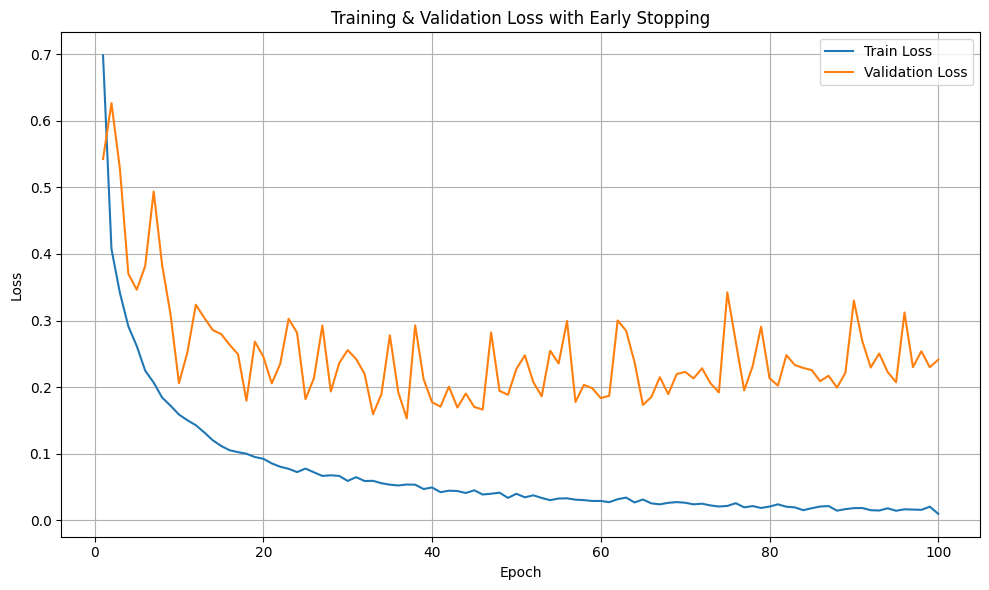

In [83]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss with Early Stopping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluando modelo...

Accuracy: 0.9647

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.72      0.77      0.74       556
           2       0.82      0.97      0.89      1448
           3       0.58      0.84      0.69       162
           4       0.97      0.99      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.81      0.91      0.85     21892
weighted avg       0.97      0.96      0.97     21892



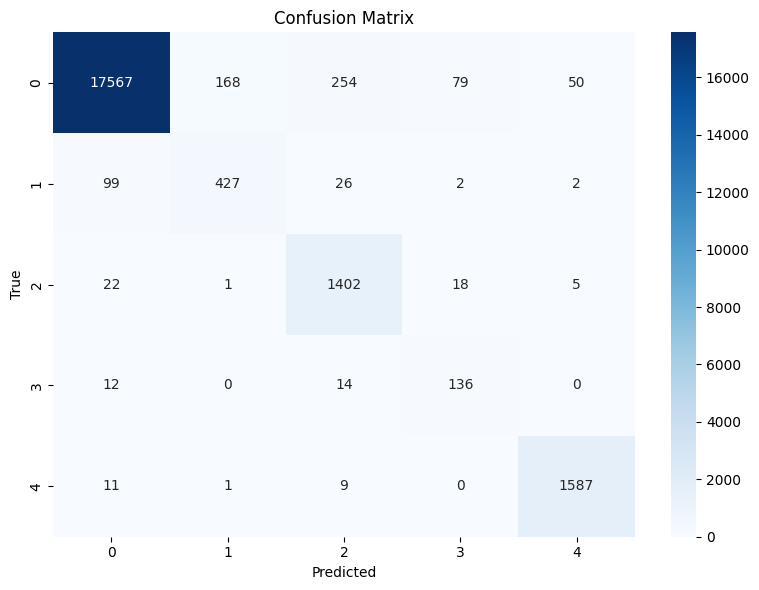


Tiempo de evaluación: 0.00 segundos
Tiempo total de ejecución: 135.38 segundos


In [84]:
print("\nEvaluando modelo...")

model.eval()

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

eval_start_time = time.time()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

eval_time = time.time() - eval_start_time

y_pred = predicted.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

accuracy = np.mean(y_pred == y_true)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred))

labels = sorted(set(y_true))
conf_mat = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

total_time = time.time() - start_time_total
print(f"\nTiempo de evaluación: {eval_time:.2f} segundos")
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")


In [85]:
torch.save(model.state_dict(), "ecg_model_cnn.pth")
print("Modelo guardado como 'ecg_model_cnn.pth'")

Modelo guardado como 'ecg_model_cnn.pth'
